In [ ]:
!python -m pip install langgraph langchain==1.1.0 openai pandas matplotlib python-dotenv

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   ----------------- ---------------------- 3.7/8.3 MB 30.6 MB/s eta 0:00:01
   --------------------------- ------------ 5.8/8.3 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 8.3/8.3 MB 3.6 MB/s  0:00:02
Using cached cycler-0.12.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import os

load_dotenv()
# -------------------------
# Configuração do modelo
# -------------------------

base_url = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com/20231130/actions/v1" 
api_key = os.getenv("OCI_API_KEY")

client = OpenAI(
    base_url=base_url,
    api_key=api_key
)

MODEL = "xai.grok-4-fast-non-reasoning"  

In [10]:
df_a = pd.DataFrame({
    "mes": ["Jan", "Feb", "Mar"],
    "regiao": ["Sul", "Sul", "Sul"],
    "vendas": [100, 120, 130]
})

df_b = pd.DataFrame({
    "mes": ["Jan", "Feb", "Mar"],
    "regiao": ["Norte", "Norte", "Norte"],
    "vendas": [90, 95, 110]
})

df = pd.concat([df_a, df_b])
df

,mes,regiao,vendas
0,Jan,Sul,100
1,Feb,Sul,120
2,Mar,Sul,130
0,Jan,Norte,90
1,Feb,Norte,95
2,Mar,Norte,110


In [11]:
def create_plan(task: str):
    prompt = f"""
    Você é um planejador analítico.

    Gere um plano em JSON com uma lista chamada "steps".
    Cada step deve ter:
    - "action": nome da ação
    - "description": descrição do que fazer

    Ações possíveis:
    - aggregate_by_month
    - aggregate_by_region
    - calculate_growth
    - generate_text_analysis
    - generate_chart

    Tarefa:
    {task}
    """

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}]
    )

    return json.loads(response.choices[0].message.content)

In [12]:
def generate_executive_text(task, data_summary):
    prompt = f"""
    Você é um analista sênior de dados.

    Tarefa:
    {task}

    Dados consolidados:
    {data_summary}

    Escreva um relatório executivo profissional,
    com insights, interpretações e recomendações.
    """

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}]
    )

    return response.choices[0].message.content

In [13]:
def execute_plan(plan, df):
    context = {}

    for step in plan["steps"]:
        action = step["action"]
        print(f"\n➡ Executando: {action}")

        if action == "aggregate_by_month":
            context["data"] = df.groupby("mes")["vendas"].sum()

        elif action == "aggregate_by_region":
            context["data"] = df.groupby("regiao")["vendas"].sum()

        elif action == "calculate_growth":
            context["growth"] = context["data"].pct_change()

        elif action == "generate_chart":
            context["data"].plot(kind="bar")
            plt.title("Visualização")
            plt.show()

        elif action == "generate_executive_summary":
            summary = str(context.get("data", ""))
            text = generate_executive_text(plan["original_task"], summary)
            context["report"] = text
            print("\n📝 Relatório Gerado:\n")
            print(text)

    return context

Plano 1:
{
  "steps": [
    {
      "action": "aggregate_by_month",
      "description": "Agregue os dados de vendas por m\u00eas para preparar a an\u00e1lise de crescimento mensal."
    },
    {
      "action": "calculate_growth",
      "description": "Calcule o crescimento percentual das vendas m\u00eas a m\u00eas com base nos dados agregados."
    },
    {
      "action": "generate_chart",
      "description": "Gere um gr\u00e1fico de linhas ou barras mostrando o crescimento mensal das vendas ao longo do tempo."
    }
  ]
}

➡ Executando: aggregate_by_month

➡ Executando: calculate_growth

➡ Executando: generate_chart


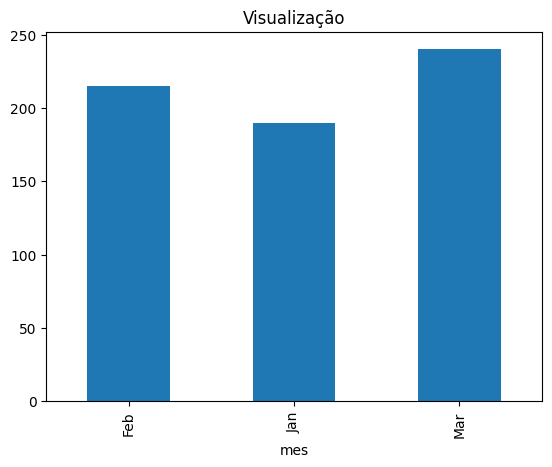

{'data': mes
 Feb    215
 Jan    190
 Mar    240
 Name: vendas, dtype: int64,
 'growth': mes
 Feb         NaN
 Jan   -0.116279
 Mar    0.263158
 Name: vendas, dtype: float64}

In [14]:
task = "Analise o crescimento mensal das vendas e gere gráfico."

plan1 = create_plan(task)

print("Plano 1:")
print(json.dumps(plan1, indent=2))

execute_plan(plan1, df)

In [17]:
task2 = "Compare vendas por região e gere uma análise textual."

plan2 = create_plan(task2)

print("Plano 2:")
print(json.dumps(plan2, indent=2))

print(execute_plan(plan2, df))

Plano 2:
{
  "steps": [
    {
      "action": "aggregate_by_region",
      "description": "Agregue os dados de vendas por regi\u00e3o para obter totais ou m\u00e9tricas resumidas por cada regi\u00e3o."
    },
    {
      "action": "generate_text_analysis",
      "description": "Gere uma an\u00e1lise textual comparando as vendas entre as regi\u00f5es, destacando diferen\u00e7as, tend\u00eancias e insights principais."
    }
  ]
}

➡ Executando: aggregate_by_region

➡ Executando: generate_text_analysis
{'data': regiao
Norte    295
Sul      350
Name: vendas, dtype: int64}
